In [1]:
#projekt Bartłomiej Malecha Mateusz Rajca
#indeks 134611;   134613
#rozróżnianie ciężarówek od samochodów

In [1]:
import os, cv2 #importowanie pakietów
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, AvgPool2D
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
FAST_RUN = False
IMAGE_WIDTH=64
IMAGE_HEIGHT=64
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
data_dir = 'C:/Users/bartek/Desktop/Datasets/'
#ścieżka plików z której algorytm będzie pobierał dane
images = []
car_types = []
for car_type in ["car","truck"]:
    car_dir = data_dir + car_type
    car_files = [car_dir + '/' + filename for filename in os.listdir(car_dir)]
    #print(car_files)
    for filename in car_files:
        if filename.endswith('jpg'):
            try:
                images.append(cv2.resize(cv2.imread(filename), (224,224), interpolation=cv2.INTER_CUBIC))
                car_types.append(car_type)
            except Exception as e:
                print(str(e))
            
            
images = np.array(images)
car_types = np.array(car_types)

le = LabelEncoder()
car_types_encoded = le.fit_transform(car_types)
car_types_encoded_onehot = np_utils.to_categorical(car_types_encoded)

OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-oduouqig\opencv\modules\imgproc\src\resize.cpp:4051: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



In [4]:
print(car_types_encoded_onehot)#podzielenie na rodzaje samochodów

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [5]:
images, car_types, car_types_encoded = shuffle(images, car_types, car_types_encoded)
car_types_encoded.resize((images.shape[0],1))
print(car_types_encoded.shape)#liczba wszystkich obrazków

(788, 1)


In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3),input_shape=(224, 224, 3),strides = (1,1), #244, 244 to rozmiar zdjęcia a 3 to rgb czyli kolory nałożone na siebie
                 padding = 'same',kernel_initializer='he_normal',
                 activation='relu'))
model.add(BatchNormalization())
#Autoamatyczna standardyzacja danych wejsciowych
#do warstwy sieci neurowej głębokiego uczenia.
model.add(AvgPool2D(pool_size=(2, 2)))
#Próbkowanie danych w dół, pobierając maksymalną wartość z okna zdefiniowanego przez 
#pool_size dla każdego wymiaru 
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 32 to ilość neuronów w sieci / warstwa sieci połączenie
model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3),strides = (1,1),  padding = 'same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=128, activation='relu', kernel_initializer='normal'))
#Gęstość sieci, czyli ile neuronów jest połączonych z każdym w następnej warstwie.
model.add(Dense(units=2, activation='sigmoid', kernel_initializer='normal'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

# 224-112-56-28-14 zmniejsza rozdzielczość, wybiera kwadraciki

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9

In [8]:
car_types_encoded = car_types_encoded.reshape((images.shape[0],1))
car_types_2class = np.zeros((images.shape[0],2))
for i in range(images.shape[0]):
    if car_types_encoded[i][0] == 0:
        car_types_2class[i][0] = 1
    else:
        car_types_2class[i][1] = 1
x_train, x_val, y_train, y_val = train_test_split(images, car_types_2class, test_size=0.2, random_state=0)
x_train = x_train / 255
x_val = x_val / 255

# ustawiamy uczenie genratora
datagen = ImageDataGenerator(rotation_range=30,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True)
datagen.fit(x_train)

In [9]:
print(car_types_2class[1:100,:]) 
# jeżeli car należy do tej klasy to daje 1 a jeśli nie to 0
#lista alej - przykładowa klasyfikacja od 1 do 100

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [10]:
print(car_types_2class)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [11]:
earlystop = EarlyStopping(patience=10)

#Earlystop, aby w razie wypadku zatzrymać uczenie gdy by nie przynosiło skutków.

In [30]:
nb_epoch = 20 #liczba epok
batch_size = 4

fitted_model = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    #steps_per_epoch = x_train.shape[0],
                    epochs=nb_epoch,
                    validation_data = (x_val, y_val),
                    )
#Tutaj wykonujemy uczenie się algorytmu na podstawie bazy

Epoch 1/20
158/158 [==============================] - 41s 262ms/step - loss: 0.6397 - accuracy: 0.6206 - val_loss: 0.6548 - val_accuracy: 0.6266
Epoch 2/20
158/158 [==============================] - 40s 256ms/step - loss: 0.6451 - accuracy: 0.6159 - val_loss: 0.6155 - val_accuracy: 0.6456
Epoch 3/20
158/158 [==============================] - 41s 260ms/step - loss: 0.6396 - accuracy: 0.6667 - val_loss: 0.6343 - val_accuracy: 0.6646
Epoch 4/20
158/158 [==============================] - 45s 283ms/step - loss: 0.6210 - accuracy: 0.6413 - val_loss: 0.6359 - val_accuracy: 0.6013
Epoch 5/20
158/158 [==============================] - 40s 252ms/step - loss: 0.6146 - accuracy: 0.6508 - val_loss: 1.0024 - val_accuracy: 0.5696
Epoch 6/20
158/158 [==============================] - 39s 247ms/step - loss: 0.6256 - accuracy: 0.6381 - val_loss: 0.6533 - val_accuracy: 0.6203
Epoch 7/20
158/158 [==============================] - 41s 260ms/step - loss: 0.6086 - accuracy: 0.6683 - val_loss: 0.6498 - val_ac

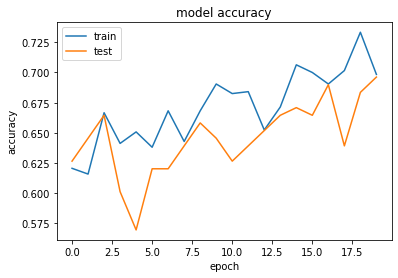

In [31]:
plt.plot(fitted_model.history['accuracy'])
plt.plot(fitted_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#Wyświetlenie modelu szybkości uczenia się i celności predykcji zdjęć
plt.show() 

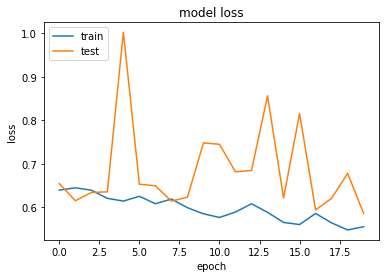

In [32]:
plt.figure()
plt.gcf().clear()
plt.plot(fitted_model.history['loss'])
plt.plot(fitted_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [33]:
from keras.applications.resnet50 import ResNet50 

def build_ResNet50(input_tensor_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape= input_tensor_shape)
    
    x_model = base_model.output
    
    x_model = AvgPool2D(name='globalaveragepooling2d')(x_model)
    
    x_model = Dense(1024, activation='relu',name='fc1_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_1')(x_model)
    x_model = Flatten()(x_model)
    x_model = Dense(256, activation='relu',name='fc2_Dense')(x_model)
    x_model = Dropout(0.5, name='dropout_2')(x_model)
    
    predictions = Dense(2, activation='sigmoid',name='output_layer')(x_model)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model



input_tensor_shape = (224,224,3)

model2 = build_ResNet50(input_tensor_shape)

model2.summary()
model2.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [19]:
nb_epoch = 10
batch_size = 4
#checkpointer = ModelCheckpoint('imagenet', verbose=1, monitor='val_acc',save_best_only=True, save_weights_only=True)
fitted_model2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    #steps_per_epoch = x_train.shape[0],
                    epochs=nb_epoch,
                    validation_data = (x_val, y_val),
                    )

Epoch 1/10
158/158 [==============================] - 371s 2s/step - loss: 1.0654 - accuracy: 0.5571 - val_loss: 0.8449 - val_accuracy: 0.4367
Epoch 2/10
158/158 [==============================] - 357s 2s/step - loss: 0.8447 - accuracy: 0.5902 - val_loss: 1.0584 - val_accuracy: 0.4747
Epoch 3/10
158/158 [==============================] - 339s 2s/step - loss: 0.6485 - accuracy: 0.6912 - val_loss: 0.7591 - val_accuracy: 0.5316
Epoch 4/10
158/158 [==============================] - 335s 2s/step - loss: 0.5366 - accuracy: 0.7627 - val_loss: 0.5241 - val_accuracy: 0.8038
Epoch 5/10
158/158 [==============================] - 328s 2s/step - loss: 0.4484 - accuracy: 0.8067 - val_loss: 0.5484 - val_accuracy: 0.7975
Epoch 6/10
158/158 [==============================] - 316s 2s/step - loss: 0.3864 - accuracy: 0.8396 - val_loss: 0.2967 - val_accuracy: 0.8418
Epoch 7/10
158/158 [==============================] - 336s 2s/step - loss: 0.3716 - accuracy: 0.8419 - val_loss: 0.2530 - val_accuracy: 0.8797

In [20]:
scores = model2.evaluate(x_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 97.62%


In [21]:
from keras.models import model_from_json

In [22]:
model_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model_json)
# serializowanie wag do HDF5
model2.save_weights("model2.h5")
print("Saved model to disk")

Saved model to disk


In [25]:
json_file = open('C:/Users/cardi/model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# załadowanie wag do nowego modelu
loaded_model.load_weights("C:/Users/cardi/model2.h5")
print("Loaded model from disk")

# ocena załadowanego modelu w porównaniu do danych testowych
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_train, y_train, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 97.62%


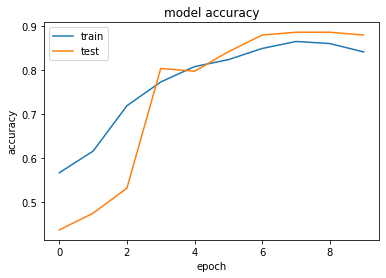

In [26]:
plt.plot(fitted_model2.history['accuracy'])
plt.plot(fitted_model2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [27]:
model2.save('C:/Users/cardi')

INFO:tensorflow:Assets written to: C:/Users/cardi\assets


In [28]:
from keras.models import load_model
import cv2
from keras.models import model_from_json
import numpy as np

json_file = open('C:/Users/cardi/model2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# załadowanie wag do nowego modelu
loaded_model.load_weights("C:/Users/cardi/model2.h5")
print("Loaded model from disk")




Loaded model from disk


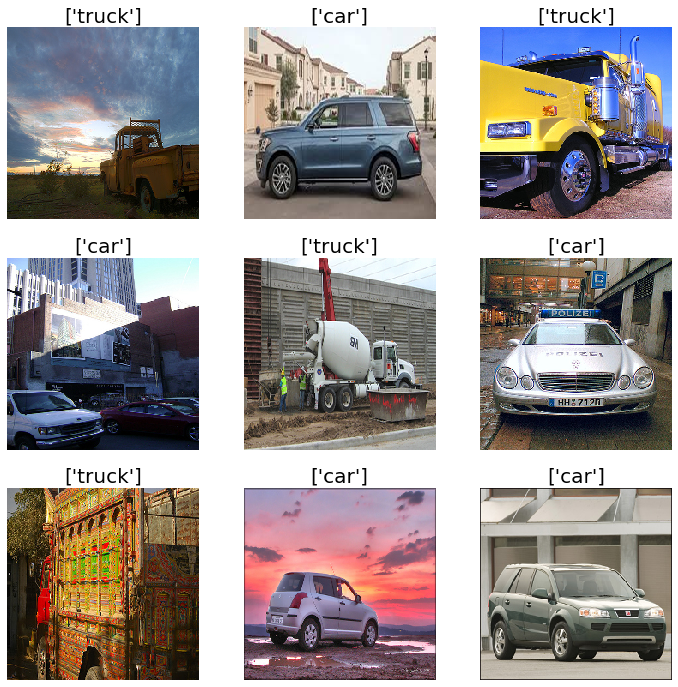

In [29]:
_, ax = plt.subplots(3,3, figsize=(12,12))
for i in range(3):
    for j in range(3):
      ax[i,j].imshow(cv2.cvtColor(images[(i*300)+j], cv2.COLOR_BGR2RGB))
      ax[i,j].axis('off')
      ax[i,j].set_title(le.inverse_transform(car_types_encoded[(i*300)+j]), size = 20)
